In [273]:
import pandas as pd
import os
import requests
from acquire import get_items, new_stores, get_stores, get_sales, combined_data, get_germany_power
from prepare import prep_combine, prep_opsd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm

In [274]:
df = pd.read_csv('Activity_data.csv')

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    225 non-null    object 
 1   Calories Burned         225 non-null    object 
 2   Steps                   225 non-null    object 
 3   Distance                225 non-null    float64
 4   Floors                  225 non-null    int64  
 5   Minutes Sedentary       225 non-null    object 
 6   Minutes Lightly Active  225 non-null    int64  
 7   Minutes Fairly Active   225 non-null    int64  
 8   Minutes Very Active     225 non-null    int64  
 9   Activity Calories       225 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


In [276]:
df['Date'] = pd.to_datetime(df.Date)

In [277]:
df = df.set_index(['Date'])

In [278]:
df = df.replace(',','', regex=True)

In [279]:
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [280]:
df

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540
...,...,...,...,...,...,...,...,...,...
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663


In [281]:
df = df.rename(columns={'Calories Burned': 'calories_burned', 'Minutes Sedentary': 'minutes_sedentary'})

In [282]:
df

,calories_burned,Steps,Distance,Floors,minutes_sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540
...,...,...,...,...,...,...,...,...,...
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663


In [283]:
df.describe()

,calories_burned,Steps,Distance,Floors,minutes_sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


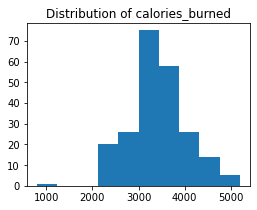

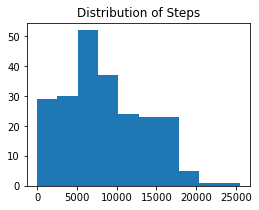

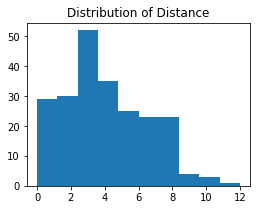

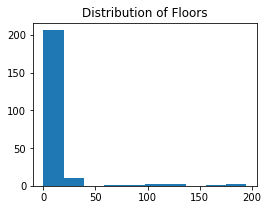

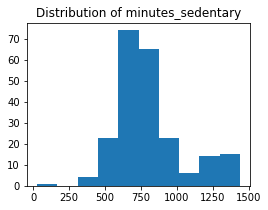

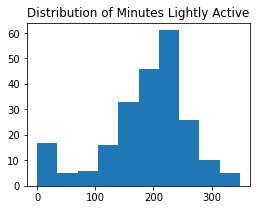

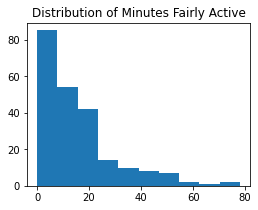

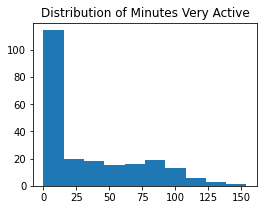

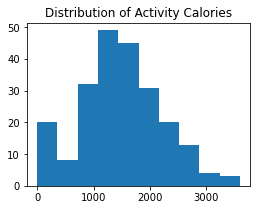

In [284]:
# 2. Plot the distribution of each of your variables.
for col in list(df):
    plt.figure(figsize = (4,3))
    plt.hist(data = df, x = col)
    plt.title(f'Distribution of {col}')
    plt.show()

In [285]:
def missing_values_table(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values, 
    and the percent of that column that has missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
        
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [286]:
# look at missing values
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [287]:
df

,calories_burned,Steps,Distance,Floors,minutes_sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540
...,...,...,...,...,...,...,...,...,...
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663


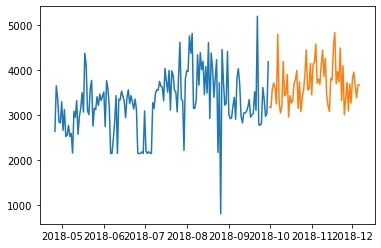

In [289]:
from sklearn.model_selection import TimeSeriesSplit

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.calories_burned)
plt.plot(test.index, test.calories_burned)

In [290]:
y = train.calories_burned
y.head()

Date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Name: calories_burned, dtype: int64

<AxesSubplot:xlabel='Date'>

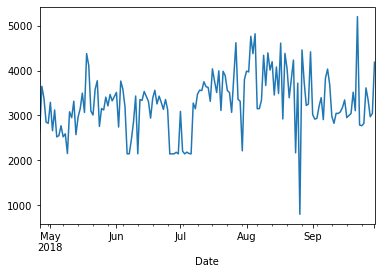

In [291]:
y.plot()

<AxesSubplot:title={'center':'2 week average'}, xlabel='Date'>

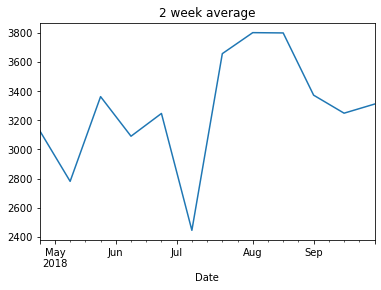

In [292]:
y.resample('2W').mean().plot(title='2 week average')